# Getting Started with Tensorflow

Tensorflow is a framework for defining and running computational graphs. It's primarily used for deep learning although it can also be used for other numerical computing and machine learning tasks.  

In [1]:
import tensorflow as tf

## Tensorflow Graphs and Sessions

Tensorflow uses computational graphs to run it's functions and models. Graphs are defined by their operations and variables.

Sessions are used to run the a graph. They create the connection between the python program and the C++ TF runtime. Setting up the graph, variables and operations can be done outside the session. But, nothing will be run until it's connected to the session and we evaluate the expression that we created.

In [2]:
# set up two variables
x = tf.Variable(32, name='x')
y = tf.Variable(45, name='y')

# set up some expression to perform on these variables
f = x*y + y*x*y

with tf.Session() as sess:
    x.initializer.run()
    y.initializer.run()
    result = f.eval()
    print('Tensorflow Output:', result)
    
print('Python Output:', 32*45 + 45*32*45)

Tensorflow Output: 66240
Python Output: 66240


# Exercise: 

Use placeholders to create a system that can add any two numbers. Since we will primarily be doing machine learning with TensorFlow we don't necessarily want the data in our graph at the start. We want to have buckets that we can put data into and get some result. Set up the same system as above except this time using placeholders so that we can pass values into it.

### Answer 

In [3]:
x = tf.placeholder(tf.int32, shape=(1,), name='x_phldr')
y = tf.placeholder(tf.int32, shape=(1,), name='y_phldr')
z = x*y + y*x*y

with tf.Session() as sess:
    result = sess.run(z, feed_dict={x:[32], y:[45]})
    
print(result)

[66240]


## Basic Linear Regression in Tensorflow

Running a basic linear regression in Tensorflow with built in optimizers and gradient descent algorithms.

In [4]:
import numpy as np
import pandas as pd
from sklearn.cross_validation import train_test_split

%matplotlib inline
import matplotlib.pyplot as plt

def normalize(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    return (data - mean) / std

/Users/florianmuellerklein/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
house_dat = pd.read_csv('Housing_data/kc_house_data.csv')
house_dat.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


Import the california housing dataset, view the shapes.

In [6]:

# load the data into numpy arrays
housing_features = house_dat[house_dat.columns.difference(['id', 'price', 'date', 'zipcode'])].values
housing_targets = house_dat.price.values
housing_targets = housing_targets / np.max(housing_targets)

n, f_dim = housing_features.shape

# normalize the features
housing_features= normalize(housing_features)

# add bias
housing_features = np.c_[np.ones((n, 1)), housing_features]

# reshape targets to TF expectation
housing_targets = np.expand_dims(housing_targets, 1)

X_train, X_test, y_train, y_test = train_test_split(housing_features,
                                                    housing_targets,
                                                    test_size=0.1)

print(X_train.shape)
print(y_train.shape)

(19451, 18)
(19451, 1)


In [7]:
LR = 0.005
EPOCHS = 5000
# save all of the losses
losses = []

X = tf.placeholder(tf.float32, shape=(None, f_dim+1), name='X')
y = tf.placeholder(tf.float32, shape=(None, 1), name='y')
W = tf.Variable(tf.ones([f_dim+1, 1]))

# after launching a session, run the initializer to initialize all of
# the variables in the graph
init = tf.global_variables_initializer()

# set up operation to get the output from the regression, 
# dot product of weight  and features
y_pred = tf.matmul(X, W)

# calculate the mean squared error
error = y_pred - y
loss = tf.reduce_mean(tf.square(error), name='mse')

# use TF's built in autograd features to run gradient descent
train_step = tf.train.GradientDescentOptimizer(LR).minimize(loss)

In [8]:
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(init)
    
    for e in range(EPOCHS):
        if e % 100 == 0:
            print("Epoch:", e, 
                  "Current loss:", 
                  sess.run(loss, feed_dict={X: X_train, y: y_train}), 
                  "Test loss:",
                 sess.run(loss, feed_dict={X: X_test, y: y_test}))
            
        sess.run(train_step, feed_dict={X: X_train, y: y_train})
        losses.append(sess.run(loss, feed_dict={X: X_train, y: y_train}))
        
    best_weights = W.eval()
    save_path = saver.save(sess, '/tmp/linear_regression.ckpt')

Epoch: 0 Current loss: 60.8474 Test loss: 59.5897
Epoch: 100 Current loss: 0.910227 Test loss: 0.878721
Epoch: 200 Current loss: 0.238915 Test loss: 0.231976
Epoch: 300 Current loss: 0.0833233 Test loss: 0.0813353
Epoch: 400 Current loss: 0.034991 Test loss: 0.0344659
Epoch: 500 Current loss: 0.0171637 Test loss: 0.0170976
Epoch: 600 Current loss: 0.00950628 Test loss: 0.00956829
Epoch: 700 Current loss: 0.00575929 Test loss: 0.00583675
Epoch: 800 Current loss: 0.00373805 Test loss: 0.00379512
Epoch: 900 Current loss: 0.00257458 Test loss: 0.0026034
Epoch: 1000 Current loss: 0.00187707 Test loss: 0.00187951
Epoch: 1100 Current loss: 0.00144814 Test loss: 0.00142887
Epoch: 1200 Current loss: 0.00117994 Test loss: 0.00114379
Epoch: 1300 Current loss: 0.00101026 Test loss: 0.000961369
Epoch: 1400 Current loss: 0.000901936 Test loss: 0.000843587
Epoch: 1500 Current loss: 0.000832271 Test loss: 0.000766953
Epoch: 1600 Current loss: 0.000787182 Test loss: 0.000716744
Epoch: 1700 Current loss

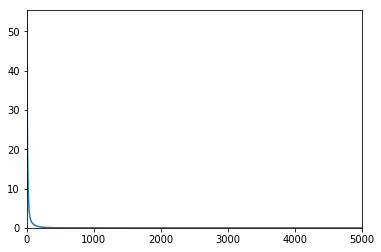

In [9]:
plt.plot(range(len(losses)),np.array(losses))
plt.axis([0,EPOCHS,np.min(losses),np.max(losses)])
plt.show()

# Exercise

### Making predictions on our test data

Now that we have our trained model, we can load it up and make predictions on our test set. Load the model from the stored state, and run the prediction function with a TensorFlow Session on the testing data.

In [10]:
# best weight values are saved in the checkpoint
with tf.Session() as sess:
    saver.restore(sess, '/tmp/linear_regression.ckpt')
    # fill in the rest below

INFO:tensorflow:Restoring parameters from /tmp/linear_regression.ckpt


### Answer

In [11]:
# best weight values are saved in the checkpoint
with tf.Session() as sess:
    saver.restore(sess, '/tmp/linear_regression.ckpt')
    preds = sess.run(y_pred, feed_dict={X: X_test})
    print(sess.run(loss, feed_dict={X: X_test, y: y_test}))

INFO:tensorflow:Restoring parameters from /tmp/linear_regression.ckpt
0.000615468


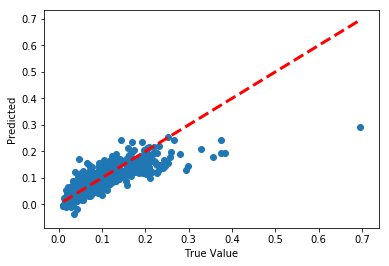

In [12]:
fig, ax = plt.subplots()
ax.scatter(y_test, preds)
ax.plot([y_test.min(), y_test.max()], 
        [y_test.min(), y_test.max()], '--', lw=3, color='r')
ax.set_xlabel('True Value')
ax.set_ylabel('Predicted')
plt.show()